In [52]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from tabulate import tabulate

# This is the Quantitative Cashflow Analysis for our Project

### First let's write down the data required for the analysis

In [53]:
client_cost_per_piece = 0.5
internal_cost_per_piece = 0.7
salvage_rate = 0.1

def dollar(amount): 
    return "${:,.2f}".format(amount)

machine = {
    'A': {
        'purchase_cost': 18000,
        'annual_maintenance_cost': 1350,
        'setup_cost': 750,
        'production_rate': 6,
        'internal_rate': 6*2
    },
    'B': {
        'purchase_cost': 27000,
        'annual_maintenance_cost': 2430,
        'setup_cost': 1000,
        'production_rate': 12,
        'internal_rate': int(12*1.5),
    },
    'C': {
        'purchase_cost': 64000,
        'annual_maintenance_cost': 4250,
        'setup_cost': 3000,
        'production_rate': 30,
        'internal_rate': 30,
    },
    'D': {
        'purchase_cost': 124000,
        'annual_maintenance_cost': 14400,
        'setup_cost': 6000,
        'production_rate': 30,
        'internal_rate': 30,
    },
}

# 1. Assumptions:<br>
- ## 200k pieces/year
Because the machines have a 1M piece life cycle and the managers want a 5 year life cycle, each year we need to produce 200K pieces for a total of 1M pieces after 5 years. Then the machines would be sold.
<br><br>

- ## Salvage value is 10% of initial price
We analysed prices from [this website](https://www.sterlingmachinery.com/new-used-lathes-sale-engine-lathe/new-used-engine-lathe.html) and determined that the average resale price is close 10% of the original prices for those machines.
<br><br>

- ## The machines will run 2 shifts/day (8 hours each)
The reason for that is that we feel like it is useless to only utilize a 1/3 of a day to produce parts as it is a waste of time and can seriously slow down the project. It is also just common industry practice to have the machines run for more than 1 shift/day. By doubling the time of production daily we can afford to cut down on the number of machines that we have to buy in order to fullfil our production requirements.
<br><br>

- ## Interest is compunded yearly (for simplicity's sake)
This will allow us to considred a single Annuity per annum at the end of each year, making which would make the analysis equivalent to paying salaries bi-weekly but simplifies our charts and calculations. In this manner there is an initial cost, 5 annuities (1 for each year) and a resale at the end of the machines' life cycle.
<br><br>

- ## 52 weeks x 5 days/week = 260 business days/year
It is assumed that all production happens during normal business days.

# 2. Let's build our functions from the ground up

In [54]:
base_hourly_salary = 14.29
extra_shift_multiplier = 0.25
benefits_multiplier = 0.63      # is applied to base pay only
manufacturing_overhead = 0.47   # is applied to direct pay

def nominal_labour_cost(days=260, shifts=2):
    '''
    Given a number of days and shifts, this function will calculate 
    the cost of 1 operator working. It will apply all multipliers and 
    necessary overhead costs.
    '''

    hourly_cost1 = (
        base_hourly_salary + 
        base_hourly_salary * benefits_multiplier + 
        base_hourly_salary * manufacturing_overhead
    )
    shift1 = days * 8 * hourly_cost1
    
    # print(f'hourly cost shift 1 = {round(hourly_cost1,2)}')

    if shifts > 1:

        extra_shifts = shifts-1
        direct_pay = base_hourly_salary * (1 + extra_shift_multiplier)
        hourly_costx = (
            direct_pay + 
            base_hourly_salary * benefits_multiplier +
            direct_pay * manufacturing_overhead
        )
        shiftx = days * 8 * extra_shifts * hourly_costx
    else:
        shiftx = 0
    
    # print(f'hourly cost for extra shifts = {round(hourly_costx,2)}')

    total_labour_cost = shift1 + shiftx

    return round(total_labour_cost,2)

In [55]:
def number_of_machines_required(machine_type, num_shifts=2, client_target=200000, internal_target=8000):
    '''
    This function tells you how many machines you need given a type and the number
    of shifts that the machines will be running (1, 2, or 3).
    '''
    
    r1 = machine[machine_type]['production_rate']
    r2 = machine[machine_type]['internal_rate']
    c1 = client_target
    c2 = internal_target
    s = num_shifts      # number of shifts per day
    d1 = 0              # days spent producing for client
    d2 = 0              # days spent producing internally

    # N*r1*(8)*s*d1 = c1
    # N*r2*(8)*s*(260-d1) = c2
    # N

    N = (c2+c1*(r2/r1))/(260*8*s*r2)  # N is the number of machines required
    N = math.ceil(N)
    d1 = math.ceil(c1/(N*r1*s*8))
    d2 = math.ceil(c2/(N*r2*s*8))

    return N, d1, d2

# 3. Cashflow analysis
In the function below we will first find the number of machines required given client and internal production targets. Then we can use the number of machines and days of production to calculate all inflows and outflows of cash.

Since we use the same machines to produce the client's part as well as ours, every year we have to setup the machines once for our client's production and once for the internal part that we wish to produce. this implies that the setup cost is part of annuities instead of being a one-time cost.

In [56]:
def cashflow_analysis(machine_type, num_shifts=2, client_target=200000, internal_target=8000):
    
    num_machines, d1, d2 = number_of_machines_required(machine_type,
                                                        num_shifts,
                                                        client_target,
                                                        internal_target
                                                    )
    
    num_days = d1 + d2
    if machine_type == 'A' or machine_type == 'B':
        operators_required = num_machines
    elif machine_type == 'C':
        operators_required = num_machines//2
    else:
        operators_required = 0

    labour_cost = operators_required * nominal_labour_cost(num_days, num_shifts)

    cash_flow = {
        'negative':{
            '1time': [
                num_machines * machine[machine_type]['purchase_cost'], 
            ],
            'annual': [
                labour_cost, 
                num_machines * machine[machine_type]['annual_maintenance_cost'],
                client_cost_per_piece * client_target,
                internal_cost_per_piece * internal_target,
                num_machines * machine[machine_type]['setup_cost'], # setup cost for client
                num_machines * machine[machine_type]['setup_cost'], # setup cost for internal
            ]
        },
        'positive':{
            '1time': [salvage_rate * machine[machine_type]['purchase_cost'] * num_machines],
            'annual': [8000*4.26] # savings when producing 8000 pieces internally
        }
    }
    
    return cash_flow

### Now let's see what the raw data for the cashflows of each machine type looks like
This data is a bit hard to parse and understand if you haven't written the code yourself. Instead we will plot and detail all of these cashflows in clear tables that you can find further down in the analysis.

In [57]:
for m in ['A', 'B', 'C', 'D']:
    print(cashflow_analysis(m))

{'negative': {'1time': [162000], 'annual': [1113759.99, 12150, 100000.0, 5600.0, 6750, 6750]}, 'positive': {'1time': [16200.0], 'annual': [34080.0]}}
{'negative': {'1time': [135000], 'annual': [561318.35, 12150, 100000.0, 5600.0, 5000, 5000]}, 'positive': {'1time': [13500.0], 'annual': [34080.0]}}
{'negative': {'1time': [128000], 'annual': [113830.14, 8500, 100000.0, 5600.0, 6000, 6000]}, 'positive': {'1time': [12800.0], 'annual': [34080.0]}}
{'negative': {'1time': [248000], 'annual': [0.0, 28800, 100000.0, 5600.0, 12000, 12000]}, 'positive': {'1time': [24800.0], 'annual': [34080.0]}}


# 4. Analysis Results 
below is some code necessary to format the data to be displayed

In [58]:
day_table = {
    'Machine Type': ['A', 'B', 'C', 'D'],
    'Machines Required': [],
    'Days Producing for Client': [],
    'Days Producing Internally': [],
    'Total Production Days': [],
}
cashflow_table = {
    'Machine Type': ['A', 'B', 'C', 'D'],
    '- Purchase Cost': [],
    '- Annual Labour Cost': [],
    '- Annual Maintenance Cost': [],
    '- Annual Client Piece Cost': [],
    '- Annual Internal Piece Cost': [],
    '- Annual Setup Cost': [],
    '+ Salvage Value': [],
    '+ Annual Internal Savings': [],
}
summary_table = {
    'Machine Type': ['A', 'B', 'C', 'D'],
    'One-time Outflow': [],
    'Annual Outflow': [],
    'Annual Inflow': [],
    'One-time Inflow': [],
}

for mtype in ['A', 'B', 'C', 'D']:
    num_machines, d1, d2 = number_of_machines_required(mtype)
    
    day_table['Machines Required'].append(num_machines)
    day_table['Days Producing for Client'].append(d1)
    day_table['Days Producing Internally'].append(d2)
    day_table['Total Production Days'].append(d1+d2)
    
    cashflow = cashflow_analysis(mtype)

    cashflow_table['- Purchase Cost'].append(cashflow['negative']['1time'][0])
    cashflow_table['- Annual Labour Cost'].append(cashflow['negative']['annual'][0])
    cashflow_table['- Annual Maintenance Cost'].append(cashflow['negative']['annual'][1])
    cashflow_table['- Annual Client Piece Cost'].append(cashflow['negative']['annual'][2])
    cashflow_table['- Annual Internal Piece Cost'].append(cashflow['negative']['annual'][3])
    cashflow_table['- Annual Setup Cost'].append(cashflow['negative']['annual'][4] + cashflow['negative']['annual'][5])
    cashflow_table['+ Salvage Value'].append(cashflow['positive']['1time'][0])
    cashflow_table['+ Annual Internal Savings'].append(cashflow['positive']['annual'][0])

    summary_table['One-time Outflow'].append(sum(cashflow['negative']['1time']))
    summary_table['Annual Outflow'].append(sum(cashflow['negative']['annual']))
    summary_table['Annual Inflow'].append(sum(cashflow['positive']['annual']))
    summary_table['One-time Inflow'].append(sum(cashflow['positive']['1time']))

def change_to_dollar(table):
    for column in table:
        if column == 'Machine Type':
            continue
        formatted = [dollar(amount) for amount in table[column]]
        table[column] = formatted

change_to_dollar(cashflow_table)
change_to_dollar(summary_table)

In [59]:
day_df = pd.DataFrame(day_table)
cashflow_df = pd.DataFrame(cashflow_table)
summary_df = pd.DataFrame(summary_table)

In [60]:
def display(df):
    print(tabulate(df.T, tablefmt='fancy_grid'))

## 4.2 Tables


In [61]:
display(day_df)
print('Table 4.2.1: Machine requirements to produce 200,000 parts for the client and 8,000 internal parts annually.')

╒═══════════════════════════╤═════╤═════╤═════╤═════╕
│ Machine Type              │ A   │ B   │ C   │ D   │
├───────────────────────────┼─────┼─────┼─────┼─────┤
│ Machines Required         │ 9   │ 5   │ 2   │ 2   │
├───────────────────────────┼─────┼─────┼─────┼─────┤
│ Days Producing for Client │ 232 │ 209 │ 209 │ 209 │
├───────────────────────────┼─────┼─────┼─────┼─────┤
│ Days Producing Internally │ 5   │ 6   │ 9   │ 9   │
├───────────────────────────┼─────┼─────┼─────┼─────┤
│ Total Production Days     │ 237 │ 215 │ 218 │ 218 │
╘═══════════════════════════╧═════╧═════╧═════╧═════╛
Table 4.2.1: Machine requirements to produce 200,000 parts for the client and 8,000 internal parts annually.


In [62]:
display(cashflow_df)
print('Table 4.2.2: Detailed Inflows(-) and Outflows(+).')

╒══════════════════════════════╤═══════════════╤═════════════╤═════════════╤═════════════╕
│ Machine Type                 │ A             │ B           │ C           │ D           │
├──────────────────────────────┼───────────────┼─────────────┼─────────────┼─────────────┤
│ - Purchase Cost              │ $162,000.00   │ $135,000.00 │ $128,000.00 │ $248,000.00 │
├──────────────────────────────┼───────────────┼─────────────┼─────────────┼─────────────┤
│ - Annual Labour Cost         │ $1,113,759.99 │ $561,318.35 │ $113,830.14 │ $0.00       │
├──────────────────────────────┼───────────────┼─────────────┼─────────────┼─────────────┤
│ - Annual Maintenance Cost    │ $12,150.00    │ $12,150.00  │ $8,500.00   │ $28,800.00  │
├──────────────────────────────┼───────────────┼─────────────┼─────────────┼─────────────┤
│ - Annual Client Piece Cost   │ $100,000.00   │ $100,000.00 │ $100,000.00 │ $100,000.00 │
├──────────────────────────────┼───────────────┼─────────────┼─────────────┼─────────────┤

In [63]:
display(summary_df)
print('Table 4.2.3: Summary of the Inflows and Outflows.')

╒══════════════════╤═══════════════╤═════════════╤═════════════╤═════════════╕
│ Machine Type     │ A             │ B           │ C           │ D           │
├──────────────────┼───────────────┼─────────────┼─────────────┼─────────────┤
│ One-time Outflow │ $162,000.00   │ $135,000.00 │ $128,000.00 │ $248,000.00 │
├──────────────────┼───────────────┼─────────────┼─────────────┼─────────────┤
│ Annual Outflow   │ $1,245,009.99 │ $689,068.35 │ $239,930.14 │ $158,400.00 │
├──────────────────┼───────────────┼─────────────┼─────────────┼─────────────┤
│ Annual Inflow    │ $34,080.00    │ $34,080.00  │ $34,080.00  │ $34,080.00  │
├──────────────────┼───────────────┼─────────────┼─────────────┼─────────────┤
│ One-time Inflow  │ $16,200.00    │ $13,500.00  │ $12,800.00  │ $24,800.00  │
╘══════════════════╧═══════════════╧═════════════╧═════════════╧═════════════╛
Table 4.2.3: Summary of the Inflows and Outflows.


In [64]:
def FP(i, N):
    return (1+i)**N


def PF(i, N):
    return 1/FP(i, N)


def AP(i, N):
    return (i*(1+i)**N)/((1+i)**N - 1)


def PA(i, N, g=None):
    if g is not None:
        return PA(i, N)/(1+g)

    return 1/AP(i, N)

## 4.3 Present Worth Comparisons

In [65]:
def PW(cashflow, i, revenue=0):
    '''
    Given some cashflow data and an interest rate i, 
    this function will calculate the present worth for a machine type.
    Additionally you could theorize an annual revenue from our client contract
    and recompute a theoretical Present Worth which takes annual revenue into account.
    '''
    pw = (
        - sum(cashflow['negative']['1time']) +
        (sum(cashflow['positive']['annual']) - sum(cashflow['negative']['annual']) + revenue) * PA(i, N=5) +
        sum(cashflow['positive']['1time'])* PF(i,N=5)
    )
    return pw

### Let's compute the PW of each machine type
We will compute one PW comparision without any annual revenue.
Then we will assume that the pieces we are selling to our client would cost similar to the pieces we are currently buying for ourselves \(\\$4.26\). This would put our annual revenue at 200,000 x 4.26 = \\$852,000.00

In [66]:
MARR = 0.15
revenue = 2e5*4.26  # we can assume that the 200,000 pieces are sold to our client at a similiar price of $4.26 that we bought our internal part

pw_table = {
    'Machine Type': ['A', 'B', 'C', 'D'],
    f'Present Worth at MARR={MARR*100}% and {dollar(0)} revenue': [],
    f'Assuming an Annual Revenue of ${dollar(revenue)}': [],
}

for mtype in ['A', 'B', 'C', 'D']:
    cashflow = cashflow_analysis(mtype)
    pw_table[f'Present Worth at MARR={MARR*100}% and {dollar(0)} revenue'].append(round(PW(cashflow, i=MARR),2))
    pw_table[f'Assuming an Annual Revenue of ${dollar(revenue)}'].append(
        round(PW(cashflow,i=MARR, revenue=revenue),2)
    )
    
pw_df = pd.DataFrame(pw_table)
change_to_dollar(pw_df)
display(pw_df)
print('Table 4.3.1 Present Worth comparision, greater is better')

╒═══════════════════════════════════════════════╤════════════════╤════════════════╤═══════════════╤═══════════════╕
│ Machine Type                                  │ A              │ B              │ C             │ D             │
├───────────────────────────────────────────────┼────────────────┼────────────────┼───────────────┼───────────────┤
│ Present Worth at MARR=15.0% and $0.00 revenue │ $-4,213,170.88 │ $-2,323,910.65 │ $-811,677.73  │ $-652,409.94  │
├───────────────────────────────────────────────┼────────────────┼────────────────┼───────────────┼───────────────┤
│ Assuming an Annual Revenue of $$852,000.00    │ $-1,357,134.73 │ $532,125.49    │ $2,044,358.41 │ $2,203,626.20 │
╘═══════════════════════════════════════════════╧════════════════╧════════════════╧═══════════════╧═══════════════╛
Table 4.3.1 Present Worth comparision, greater is better


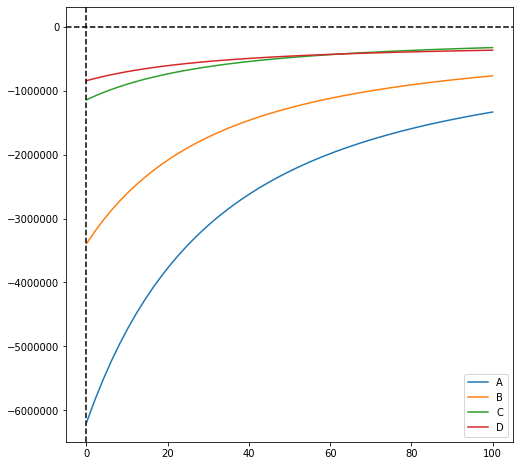

In [67]:

def add_origin():
    plt.axhline(color='black', linestyle='--')
    plt.axvline(color='black', linestyle='--')

def plot_pw():
    for mtype in ['A', 'B', 'C', 'D']:
        cashflow = cashflow_analysis(mtype)
        domain = np.linspace(0.1, 100)
        image = np.array([PW(cashflow, i/100) for i in domain])
        plt.plot(domain, image)
    plt.legend(['A', 'B', 'C', 'D'])
    add_origin()

plt.figure(figsize=(8,8))
plot_pw()